In [15]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

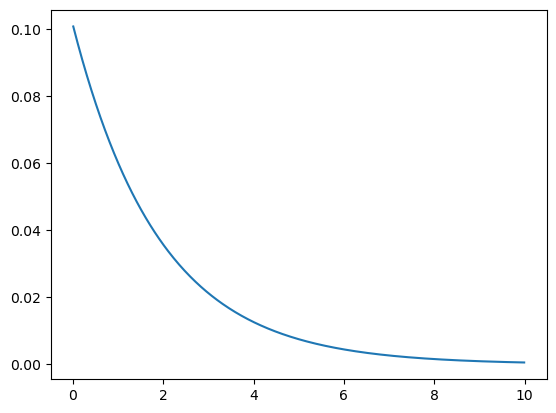

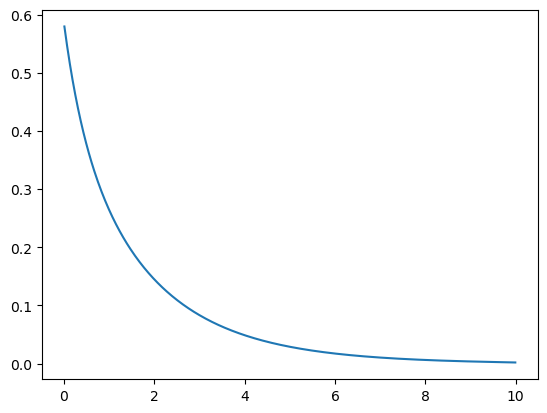

0.005721666655487622
0.003502637877741163
0.0022236718655872676
0.0012940204509587117
0.0006999827107522038
0.0003617879096710339
0.00018233808947455538
9.06975820909082e-05
4.481549845044512e-05
2.2071048121878606e-05
1.0851922712477244e-05


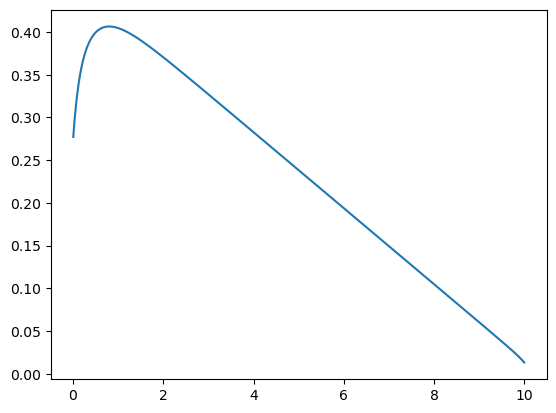

0.006793435923524785
0.00560634288780245
0.004557717925706304
0.0033218122244456742
0.0021411859250705196
0.0012420638408794865
0.0006694364364624655
0.00034522249588796877
0.00017377827748343285
8.638608461560666e-05
4.2671808181629684e-05
2.101206409088502e-05
1.0330453239572529e-05


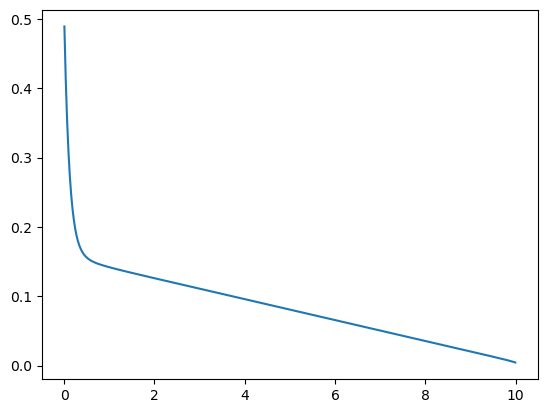

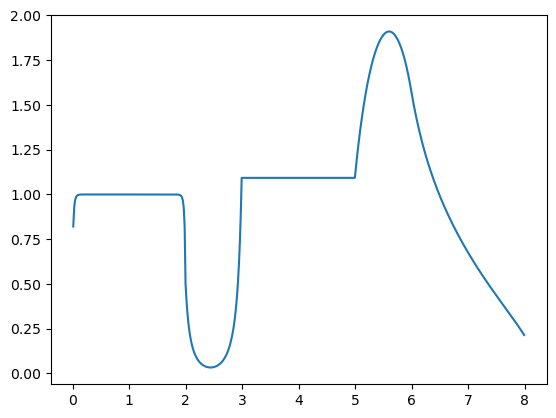

In [16]:
class Quadrature:
    def __init__(self, order):
        assert order % 2 == 0, "Quadrature order must be even"
        self.mus, self.weights = scipy.special.roots_legendre(order)

    def get_quadrature(self):
        return self.mus, self.weights


class Mesh:
    def __init__(self, max_mesh_width, num_points):
        self.mesh, self.dx = np.linspace(0, max_mesh_width, num_points, retstep=True)
        self.num_cells = num_points - 1

    def get_mesh(self):
        return self.mesh, self.dx, self.num_cells

class MaterialProperties:
    def __init__(self, sigma_t_zones, sigma_s_zones, q_zones, mesh):
        num_cells = mesh.size - 1
        self.sigma_t = np.zeros(num_cells)
        self.sigma_s = np.zeros(num_cells)
        self.ext_src = np.zeros(num_cells)

        # Compute midpoints of cells
        midpoints = 0.5 * (mesh[:-1] + mesh[1:])

        # Assign material properties efficiently using NumPy boolean masks
        for zone, sigma_t in sigma_t_zones.items():
            mask = (zone[0] <= midpoints) & (midpoints <= zone[1])
            self.sigma_t[mask] = sigma_t
            self.sigma_s[mask] = sigma_s_zones[zone]
            self.ext_src[mask] = q_zones[zone]

    def return_xs_and_sources_for_mesh(self):
        return self.sigma_t, self.sigma_s, self.ext_src

class Solver:
    def __init__(self, psi_left, psi_right, sigma_t_zones, sigma_s_zones, zones_q,
                max_mesh_width, num_mesh_points, quad_order,
                solver_type="diamond-difference"):
        self.psi_left = psi_left 
        self.psi_right = psi_right
        self.sigma_t_zones = sigma_t_zones
        self.sigma_s_zones = sigma_s_zones
        self.zones_q       = zones_q
        self.max_mesh_width = max_mesh_width
        self.num_mesh_points = num_mesh_points
        self.quad_order     = quad_order
        self.solver_type    = solver_type

        # Extract mesh
        self.mesh_obj = Mesh(self.max_mesh_width, self.num_mesh_points)
        self.mesh, self.mesh_dx, self.mesh_num_cells = self.mesh_obj.get_mesh()

        # Extract mesh material properties
        self.mat_props_obj = MaterialProperties(self.sigma_t_zones, self.sigma_s_zones,
                                            self.zones_q, self.mesh)
        self.sigma_t, self.sigma_s, self.ext_src = self.mat_props_obj.return_xs_and_sources_for_mesh()

        # Extract quadrature rules
        self.quad_rules_obj = Quadrature(self.quad_order)
        self.mus, self.weights = self.quad_rules_obj.get_quadrature()
        
        # Assure positivity of fluxes if using diamond-differencing
        # assert np.mind(self.sigma_t * self.mesh_dx/np.abs(self.mus) < 1.0, "Diamond-difference stability condition not met"

        # Initial guesses to perform source iteration
        self.curr_scalar_fluxes = np.full((self.mesh_num_cells, ), np.log(2))
        self.new_scalar_fluxes  = np.zeros_like(self.curr_scalar_fluxes)

        self.eps = 1e-5 # Relative error tolerance
        self.iter_count = 0 # Iteration counter
        self.max_scalar_flux_rel_err = np.max(np.abs((self.new_scalar_fluxes - self.curr_scalar_fluxes)/
                                                 self.curr_scalar_fluxes))
        
    def plot_scalar_fluxes(self):
        mesh_centers = 0.5 * (self.mesh[:-1] + self.mesh[1:])
        plt.figure()
        plt.plot(mesh_centers, self.curr_scalar_fluxes)
        plt.show()

    def run(self):
        # Perform source iteration until scalar flux relative error (in all mesh cells)
        # between previous and current scalar flux iterates is below eps
        while True:
            self.iter_count += 1

            # Compute source term
            curr_source_term = 0.5 * (self.ext_src + self.sigma_s * self.curr_scalar_fluxes)

            # Loop over angles
            for mu_d, mu in enumerate(self.mus):
                # Determine the traversal order
                traversing_forward = mu < 0.0

                starting_cell_idx = 0 if traversing_forward else (self.mesh_num_cells - 1)
                ending_cell_idx = self.mesh_num_cells if traversing_forward else -1
                cell_step_idx = 1 if traversing_forward else -1

                # psi_{d, i} = a*psi_{d, i+1/2} + (1-a) psi_{d, i-1/2}, 0 <= a <= 1
                # Step scheme: a = 0 for mu > 0 and a = 1 for mu < 0
                # Diamond-difference scheme: a = 1/2
                # pf1 = (1 - 1/2 * sigma_t * dx / |mu|) psi_d_in = 
                # pf2 = 1/2
                pf1, pf2, pf3, pf4 = None, None, None, None
                if self.solver_type == 'diamond_difference':
                    pf1, pf2, pf3, pf4 = 0.5, 0.5, 0.5, 0.5
                elif self.solver_type == 'step': # Step scheme
                    pf1, pf2 = 1.0, 1.0
                    pf3      = 1.0 if traversing_forward else 0.0
                    pf4      = 0.0 if traversing_forward else 1.0
                else:
                    raise ValueError("Unknown solver type")
                
                # Extract incident flux, depending on traversal order
                psi_d_in = self.psi_left[mu_d] if traversing_forward else self.psi_right[mu_d]

                # Auxiliary term
                dx_div_abs_mu = self.mesh_dx / np.abs(mu)

                # Loop over cells
                for i in np.arange(starting_cell_idx, ending_cell_idx, cell_step_idx):
                    sigma_t_mult_dx_abs_mu = self.sigma_t[i] * dx_div_abs_mu
                    
                    # psi_d_out = (curr_source_term[i] * dx_div_abs_mu + (1 - (1 - a) * sigma_t_mult_dx_abs_mu) * psi_d_in) / \
                    #                 (1 + a * sigma_t_mult_dx_abs_mu)
                    psi_d_out = (curr_source_term[i]*dx_div_abs_mu + (1 - (1-pf1) * sigma_t_mult_dx_abs_mu)*psi_d_in) / \
                                    (1 + pf2*sigma_t_mult_dx_abs_mu)
                    
                    psi_d =  pf3*psi_d_out + pf4*psi_d_in
                    
                    # print(f"i: {i}, mu: {mu}, psi_d_in: {psi_d_in}, psi_d_out: {psi_d_out}, psi_d: {psi_d}")
                    
                    psi_d_in = psi_d_out

                    # Update scalar flux, cell by cell
                    self.new_scalar_fluxes[i] += psi_d * self.weights[mu_d]


            # Compute relative error between two most recent scalar flux iterates
            # print(self.curr_scalar_fluxes)
            # print(self.new_scalar_fluxes)
            if (self.iter_count % 100 == 0):
                print(self.max_scalar_flux_rel_err)
                
            self.max_scalar_flux_rel_err = np.max(np.abs((self.new_scalar_fluxes - self.curr_scalar_fluxes)/ \
                                                  self.curr_scalar_fluxes))
            
            # Update scalar fluxes
            self.curr_scalar_fluxes = np.copy(self.new_scalar_fluxes)
            self.new_scalar_fluxes[:] = 0.0
            
            if ((self.max_scalar_flux_rel_err <= self.eps)):
                break
            
        # Plot the scalar fluxes 
        self.plot_scalar_fluxes()

if __name__ == '__main__':
    # Problem 1
    mesh_width = 10.0
    num_mesh_points = 500

    quadrature_order = 8

    psi_left = np.zeros((quadrature_order, ))
    psi_left[0] = 1.0

    psi_right = np.zeros((quadrature_order, ))

    sigma_t_zones = {}
    sigma_t_zones[(0.0, mesh_width)] = 0.5

    sigma_s_zones = {}
    sigma_s_zones[(0.0, mesh_width)] = 0.0

    q_zones = {}
    q_zones[(0.0, mesh_width)] = 0.0

    problem_1_solver = Solver(psi_left, psi_right, sigma_t_zones, sigma_s_zones, 
                              q_zones,
                              mesh_width, num_mesh_points, quadrature_order,
                              solver_type="diamond_difference")
    problem_1_solver.run()
    
    # Problem 2
    mesh_width = 10.0
    num_mesh_points = 500

    quadrature_order = 8

    psi_left = 0.5 * np.ones((quadrature_order, ))

    psi_right = np.zeros((quadrature_order, ))

    sigma_t_zones = {}
    sigma_t_zones[(0.0, mesh_width)] = 0.5

    sigma_s_zones = {}
    sigma_s_zones[(0.0, mesh_width)] = 0.25

    q_zones = {}
    q_zones[(0.0, mesh_width)] = 0.0

    problem_2_solver = Solver(psi_left, psi_right, sigma_t_zones, sigma_s_zones, 
                              q_zones,
                              mesh_width, num_mesh_points, quadrature_order,
                              solver_type="diamond_difference")
    problem_2_solver.run()

    ####
    # Problem 3
    mesh_width = 10.0
    num_mesh_points = 1000

    quadrature_order = 8

    psi_left = np.zeros((quadrature_order, ))
    psi_left[0] = 1.0

    psi_right = np.zeros((quadrature_order, ))

    sigma_t_zones = {}
    sigma_t_zones[(0.0, mesh_width)] = 2.0

    sigma_s_zones = {}
    sigma_s_zones[(0.0, mesh_width)] = 2.0

    q_zones = {}
    q_zones[(0.0, mesh_width)] = 0.0

    problem_3_solver = Solver(psi_left, psi_right, sigma_t_zones, sigma_s_zones, 
                              q_zones, mesh_width, num_mesh_points, quadrature_order,
                              solver_type="diamond_difference")
    problem_3_solver.run()
    
    # Problem 4
    mesh_width = 10.0
    num_mesh_points = 1000

    quadrature_order = 8

    # Unit incident flux on left extremity is along the most grazing direction 
    psi_left = np.zeros((quadrature_order, ))
    grazing_direction_on_left = int(quadrature_order/2) - 1
    psi_left[grazing_direction_on_left] = 1.0

    psi_right = np.zeros((quadrature_order, ))

    sigma_t_zones = {}
    sigma_t_zones[(0.0, mesh_width)] = 2.0

    sigma_s_zones = {}
    sigma_s_zones[(0.0, mesh_width)] = 2.0

    q_zones = {}
    q_zones[(0.0, mesh_width)] = 0.0

    problem_4_solver = Solver(psi_left, psi_right, sigma_t_zones, sigma_s_zones, 
                              q_zones, mesh_width, num_mesh_points, quadrature_order,
                              solver_type="diamond_difference")
    problem_4_solver.run()

    # Reed problem
    mesh_width = 8.0
    num_mesh_points = 500

    quadrature_order = 8
    psi_left = np.zeros((quadrature_order, ))
    psi_right = np.zeros((quadrature_order, ))

    sigma_t_zones = {}
    sigma_t_zones[(0.0, 2.0)] = 50.0
    sigma_t_zones[(2.0, 3.0)] = 5.0
    sigma_t_zones[(3.0, 5.0)] = 0.0
    sigma_t_zones[(5.0, 6.0)] = 1.0
    sigma_t_zones[(6.0, 8.0)] = 1.0

    sigma_s_zones = {}
    sigma_s_zones[(0.0, 2.0)] = 0.0
    sigma_s_zones[(2.0, 3.0)] = 0.0
    sigma_s_zones[(3.0, 5.0)] = 0.0
    sigma_s_zones[(5.0, 6.0)] = 0.9
    sigma_s_zones[(6.0, 8.0)] = 0.9

    q_zones = {}
    q_zones[(0.0, 2.0)] = 50.0
    q_zones[(2.0, 3.0)] = 0.0
    q_zones[(3.0, 5.0)] = 0.0
    q_zones[(5.0, 6.0)] = 1.0
    q_zones[(6.0, 8.0)] = 0.0

    problem_5_solver = Solver(psi_left, psi_right, sigma_t_zones, sigma_s_zones,
                              q_zones, mesh_width, num_mesh_points, quadrature_order,
                              solver_type="step")
    problem_5_solver.run()
    

